In [2]:
import re, os
import random, math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime

os.chdir("/home/technocracy90/Datathon")

print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

2.18.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Kaggle 데이터 다운로드
import kagglehub
netflix_path = kagglehub.dataset_download("shivamb/netflix-shows")
amazon_path = kagglehub.dataset_download("shivamb/amazon-prime-movies-and-tv-shows")
disney_path = kagglehub.dataset_download("shivamb/disney-movies-and-tv-shows")

# 저장된 경로 확인
print(netflix_path)
print(amazon_path)
print(disney_path)

# cash 디렉토리에서 작업 디렉토리로 복사
from distutils.dir_util import copy_tree
root_path = os.path.join(os.getenv('HOME'), 'Datathon')
copy_tree(netflix_path, root_path)
copy_tree(amazon_path, root_path)
copy_tree(disney_path, root_path)

# 데이터 경로 업데이트

def update_path(data_path):
    name = data_path.split("/")[-3]
    name = name.split("-")[0]

    for file in os.listdir(root_path):
        filename, extension = os.path.splitext(file)
        filename = filename.split("_")[0]
        if extension == ".csv" and name == filename:
            return  os.path.join(root_path, file)

netflix_path = update_path(netflix_path)
amazon_path = update_path(amazon_path)
disney_path = update_path(disney_path)

# 저장된 경로 확인
print(netflix_path)
print(amazon_path)
print(disney_path)

/home/technocracy90/.cache/kagglehub/datasets/shivamb/netflix-shows/versions/5
/home/technocracy90/.cache/kagglehub/datasets/shivamb/amazon-prime-movies-and-tv-shows/versions/1
/home/technocracy90/.cache/kagglehub/datasets/shivamb/disney-movies-and-tv-shows/versions/2
/home/technocracy90/Datathon/netflix_titles.csv
/home/technocracy90/Datathon/amazon_prime_titles.csv
/home/technocracy90/Datathon/disney_plus_titles.csv


In [4]:
# 데이터 적재
netflix = []
netflix = pd.read_csv(netflix_path)
amazon = pd.read_csv(amazon_path)
disney = pd.read_csv(disney_path)

netflix

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


In [5]:
#id 패딩 함수
def pad_show_id(show_id):
    pattern = re.compile(r"s(\d+)")
    result = pattern.sub(lambda match: f"s{int(match.group(1)):04d}", show_id)
    return result

netflix['show_id'] = netflix['show_id'].apply(pad_show_id)
amazon['show_id'] = amazon['show_id'].apply(pad_show_id)
disney['show_id'] = disney['show_id'].apply(pad_show_id)

print(netflix.info())
print(amazon.info())
print(disney.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9668 entries, 0 to 9667
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       9668 non-null   object
 1   type     

In [6]:
netflix['type'] = pd.get_dummies(netflix['type'], drop_first=True, dtype = 'int')
netflix.rename(columns = {'type' : 'TV Show'}, inplace = True)

disney['type'] = pd.get_dummies(disney['type'], drop_first=True, dtype = 'int')
disney.rename(columns = {'type' : 'TV Show'}, inplace = True)

amazon['type'] = pd.get_dummies(amazon['type'], drop_first=True, dtype = 'int')
amazon.rename(columns = {'type' : 'TV Show'}, inplace = True)

In [7]:
def date_and_time(dataframe):
    dataframe['date_added'] = dataframe['date_added'].astype('str')
    dataframe['release_year'] = dataframe['release_year'].astype('str')
    counter_release = 0
    counter_added = 0
    
    for entry, index in zip(dataframe['release_year'], dataframe.index):
        if type(entry) != datetime:
            try:
                dataframe.at[index, 'release_year'] = datetime.strptime(str(entry), "%Y")
            except Exception as e:
                counter_release += 1
                print(f"{e}:\n{index}, {entry}")

    
    for entry, index in zip(dataframe['date_added'], dataframe.index):
        try:
            dataframe.at[index, 'date_added'] = datetime.strptime(entry.lstrip(), "%B %d, %Y")
        except Exception as e:
            counter_added += 1
            dataframe.at[index, 'date_added'] = dataframe.at[index, 'release_year']
    
    print(f'{counter_release} release_dates have not converted!')
    print(f'{counter_added} date_added were missing!')

In [8]:
date_and_time(netflix)
date_and_time(amazon)
date_and_time(disney)

0 release_dates have not converted!
10 date_added were missing!
0 release_dates have not converted!
9513 date_added were missing!
0 release_dates have not converted!
3 date_added were missing!


In [9]:
netflix_recent = netflix[netflix["release_year"] > datetime.strptime("2018", "%Y")]
netflix_recent.reset_index()

,index,show_id,TV Show,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,0,s0001,0,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25 00:00:00,2020-01-01 00:00:00,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,1,s0002,1,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24 00:00:00,2021-01-01 00:00:00,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,2,s0003,1,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24 00:00:00,2021-01-01 00:00:00,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,3,s0004,1,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24 00:00:00,2021-01-01 00:00:00,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,4,s0005,1,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24 00:00:00,2021-01-01 00:00:00,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,8516,s8517,0,The Spy Who Fell to Earth,Thomas Meadmore,NaN,United Kingdom,2019-04-05 00:00:00,2019-01-01 00:00:00,TV-MA,94 min,"Documentaries, International Movies","Based on Dr. Ahron Bregman's book, this docume..."
2571,8631,s8632,0,Trixie Mattel: Moving Parts,Nicholas Zeig-Owens,Brian Firkus,United States,2020-03-27 00:00:00,2019-01-01 00:00:00,TV-MA,91 min,"Documentaries, Music & Musicals",Drag queen Trixie Mattel deals with the bitter...
2572,8718,s8719,0,Westside vs. the World,Michael Fahey,"Ron Perlman, Louie Simmons",NaN,2019-08-09 00:00:00,2019-01-01 00:00:00,TV-MA,96 min,"Documentaries, Sports Movies",A look into the journey of influential strengt...
2573,8752,s8753,0,Wish Man,Theo Davies,"Andrew Steel, Kirby Bliss Blanton, Tom Sizemor...",United States,2019-12-03 00:00:00,2019-01-01 00:00:00,TV-14,108 min,"Children & Family Movies, Dramas","After surviving a life-threatening accident, a..."


In [10]:
def split_and_encode(dataframe, column, replace_dict = {}):
    mlb = MultiLabelBinarizer()
    temp = dataframe[column].str.split(",", expand = True)

    for i in range(temp.shape[1]):
        temp[i] = temp[i].apply(lambda x: str(x).lstrip()) # it also converts "None" to str

    if replace_dict:
        temp.replace(replace_dict, inplace = True)

    temp = pd.DataFrame(mlb.fit_transform(temp.values.tolist()), columns=mlb.classes_)
    temp.drop(["None"], axis=1, inplace = True)

    try:
        temp.drop([""], axis = 1, inplace = True)
    except:
        pass
    
    try:
        temp.drop(["nan"], axis = 1, inplace = True)
    except:
        pass

    # for index in dataframe.index:
    #     dataframe.at[index, column] = temp.sum(axis=1)[index]

    return temp

def read_replace_map(filename):
    replace_dict = {}

    with open(filename, 'r') as file:
        lines = file.readlines()

    for line in lines:
        key,value = line.strip().split(" = ")
        replace_dict[key.strip("'")] = value.strip("'")

    return replace_dict

In [ ]:
netflix_country = split_and_encode(netflix, "country")
amazon_country = split_and_encode(amazon, "country")
disney_country = split_and_encode(disney, "country")

netflix = pd.concat([netflix, netflix_country], axis=1)
amazon = pd.concat([amazon, amazon_country], axis=1)
disney = pd.concat([disney, disney_country], axis=1)

In [ ]:
replace_map = read_replace_map('listed_in_replace_map.txt')
print(replace_map)

netflix_genre = split_and_encode(netflix, "listed_in", replace_map)
disney_genre = split_and_encode(disney, "listed_in", replace_map)
amazon_genre = split_and_encode(amazon, "listed_in", replace_map)

netflix = pd.concat([netflix, netflix_genre], axis=1)
amazon = pd.concat([amazon, amazon_genre], axis=1)
disney = pd.concat([disney, disney_genre], axis=1)

In [38]:
replace_map = read_replace_map('listed_in_replace_map.txt')
netflix_recent_genre = split_and_encode(netflix, "listed_in", replace_map)

In [ ]:
netflix.to_csv(os.path.join(root_path, "netflixEDA.csv"))
amazon.to_csv(os.path.join(root_path, "amazonEDA.csv"))
disney.to_csv(os.path.join(root_path, "disneyEDA.csv"))

In [ ]:
plt.figure(figsize=(30,10))
g = sns.boxplot(x = netflix_genre.columns, y = np.log10(netflix_genre.sum()))
g.set_xticklabels(labels = netflix_genre.columns, rotation = 30)
plt.show

In [ ]:
netflix_country

In [11]:
netflix_recent_countries = split_and_encode(netflix_recent, "country")
netflix_recent_countries

,Algeria,Angola,Argentina,Australia,Austria,Belgium,Brazil,Bulgaria,Cameroon,Canada,...,Sweden,Syria,Taiwan,Thailand,Turkey,United Arab Emirates,United Kingdom,United States,Uruguay,Vietnam
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2573,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
netflix_country_relevant = netflix_country[netflix_country.sum()[netflix_country.sum() > 50].index]
netflix_country_relevant.corr()

In [12]:
netflix_recent_countries_relevant = netflix_recent_countries[netflix_recent_countries.sum()[netflix_recent_countries.sum() > 10].index]
netflix_recent_countries_relevant.corr()

,Argentina,Australia,Belgium,Brazil,Canada,China,Colombia,Egypt,France,Germany,...,Poland,South Africa,South Korea,Spain,Sweden,Taiwan,Thailand,Turkey,United Kingdom,United States
Argentina,1.000000,-0.013464,-0.010079,-0.014964,-0.021250,-0.014643,-0.009606,-0.007111,-0.020423,-0.016188,...,-0.008311,-0.008585,-0.019189,0.001671,-0.007111,-0.010079,-0.010079,-0.009361,-0.029047,-0.063115
Australia,-0.013464,1.000000,-0.011512,-0.017091,-0.007403,-0.016725,-0.010972,-0.008123,-0.005825,0.025111,...,-0.009493,-0.009806,-0.021918,-0.022062,-0.008123,-0.011512,-0.011512,-0.010692,0.017766,-0.064893
Belgium,-0.010079,-0.011512,1.000000,0.018403,-0.018169,-0.012520,-0.008213,-0.006080,0.214791,0.015088,...,-0.007106,-0.007340,-0.016407,0.032422,0.058617,-0.008617,-0.008617,-0.008004,0.076567,-0.038336
Brazil,-0.014964,-0.017091,0.018403,1.000000,-0.011742,-0.018588,-0.012194,-0.009027,0.005683,-0.020549,...,-0.010550,-0.010898,-0.024359,0.008781,-0.009027,-0.012794,-0.012794,-0.011883,-0.025372,-0.102569
Canada,-0.021250,-0.007403,-0.018169,-0.011742,1.000000,0.004711,-0.017316,-0.012820,0.008543,-0.015057,...,-0.014982,-0.015476,-0.022571,-0.010926,-0.012820,-0.018169,-0.018169,-0.016875,0.030155,0.011277
China,-0.014643,-0.016725,-0.012520,-0.018588,0.004711,1.000000,-0.011932,-0.008834,-0.025369,-0.000008,...,-0.010324,-0.010664,0.044590,-0.006992,-0.008834,0.083048,0.019336,-0.011628,0.034377,-0.051857
Colombia,-0.009606,-0.010972,-0.008213,-0.012194,-0.017316,-0.011932,1.000000,-0.005795,0.007707,-0.013192,...,-0.006772,-0.006996,-0.015637,0.009912,-0.005795,-0.008213,-0.008213,-0.007628,-0.023670,-0.042330
Egypt,-0.007111,-0.008123,-0.006080,-0.009027,-0.012820,-0.008834,-0.005795,1.000000,-0.012321,0.031058,...,-0.005014,-0.005179,-0.011576,-0.011653,-0.004290,-0.006080,-0.006080,-0.005647,-0.017524,-0.051553
France,-0.020423,-0.005825,0.214791,0.005683,0.008543,-0.025369,0.007707,-0.012321,1.000000,0.045229,...,-0.014399,-0.014874,-0.020774,0.053303,-0.012321,-0.017462,-0.017462,-0.016218,0.026729,-0.077683
Germany,-0.016188,0.025111,0.015088,-0.020549,-0.015057,-0.000008,-0.013192,0.031058,0.045229,1.000000,...,-0.011413,-0.011790,-0.026352,0.035232,-0.009766,-0.013841,-0.013841,-0.012855,0.024095,-0.079006


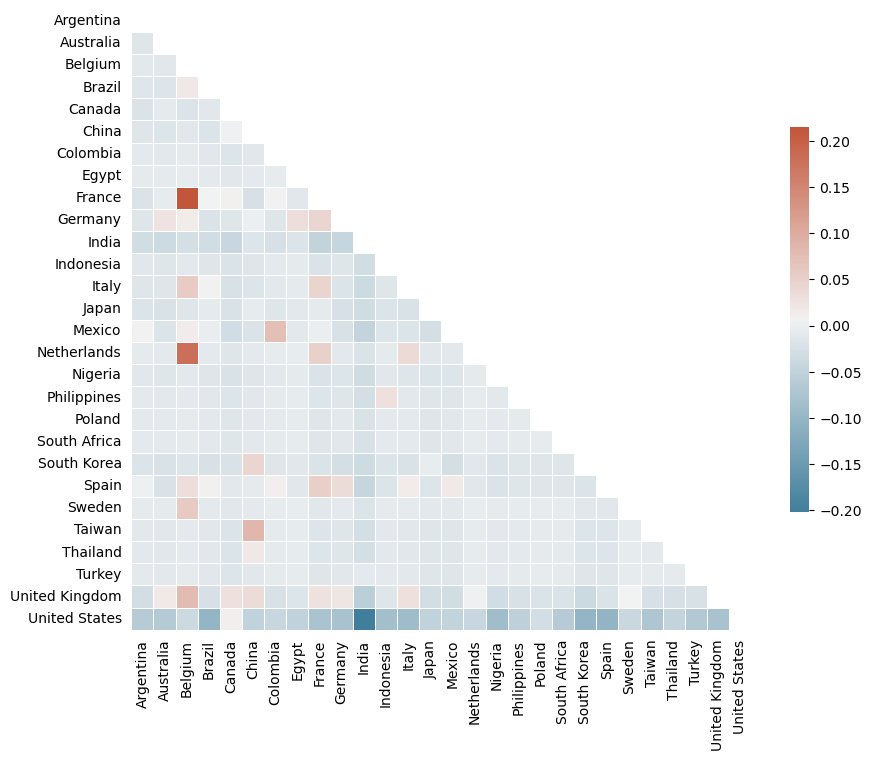

In [36]:
corr = netflix_recent_countries_relevant.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(10,10))
g = sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": .5})
g.set(xlabel="", ylabel="", aspect="equal")
g.tick_params(bottom=False, left=False)